In [117]:
import math
import random
import pygame
import sys
import numpy as np
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torch_geometric.data import Data, InMemoryDataset, download_url, TemporalData
import torch.nn as nn
from torch_geometric.nn import GCNConv
from tqdm import tqdm
from torch_geometric.nn import ChebConv
import torch.optim as optim


In [118]:
path_to_sim_edges = '../data/simulation_edges.csv'
sim_edges_df = pd.read_csv(path_to_sim_edges)

path_to_sim = '../data/simulation.csv'
sim_df = pd.read_csv(path_to_sim)


sim_edges_df.head(5)

frame_rate = 1

sim_edges_df= sim_edges_df[sim_edges_df['Timestep']% frame_rate== 0]
sim_df= sim_df[sim_df['Timestep']% frame_rate== 0]

sim_edges_df_final = sim_edges_df[sim_edges_df['Simulation'] == 0]
sim_df_final = sim_df[sim_df['Simulation'] == 0]

testing_edges = sim_edges_df[sim_edges_df['Simulation'] == 1]
testing = sim_df[sim_df['Simulation'] == 1]

total_length = len(testing)
total_length_edges = len(testing_edges)

subset_length = math.ceil(total_length * 0.2)  # Get 20% of the total data
subset_length_edges = math.ceil(total_length_edges * 0.2)  # Get 20% of the total data

testing_edges_20 = testing_edges[:subset_length_edges]
testing_20 = testing[:subset_length]
import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from torch_geometric.data import Data
from scipy.spatial.distance import pdist, squareform

def compute_edge_features(node_features, edge_index):
    num_edges = edge_index.shape[1]
    edge_features = torch.zeros(num_edges, dtype=torch.float)

    for i in range(num_edges):
        boid_i = edge_index[0, i].item()
        boid_j = edge_index[1, i].item()

        x_i, y_i = node_features[boid_i, 0].item(), node_features[boid_i, 1].item()
        x_j, y_j = node_features[boid_j, 0].item(), node_features[boid_j, 1].item()

        # Compute Euclidean distance
        distance = np.sqrt((x_i - x_j) ** 2 + (y_i - y_j) ** 2)

        # Set the edge feature as the distance between boids
        edge_features[i] = distance

    return edge_features

def toDataGraph(sim_df, sim_edges_df, node_features_names):
    node_features = torch.tensor(sim_df[node_features_names].to_numpy(), dtype=torch.float)
    edge_index = torch.tensor(sim_edges_df[['Boid_i', 'Boid_j']].to_numpy().T, dtype=torch.long)
    
    # Calculate edge attributes based on distance
    edge_attr = compute_edge_features(node_features, edge_index)
    
    # Create and return the Data object
    graph = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)
    return graph

def allDataGraph(sim_df, sim_edges_df):
    sim_gb_df = sim_df.groupby(['Timestep', 'Simulation'])
    sim_edges_gb_df = sim_edges_df.groupby(['Timestep', 'Simulation'])

    graphs = []
    for key, _ in sim_gb_df:
        curr_sim_df = sim_gb_df.get_group(key)
        curr_sim_edges_df = sim_edges_gb_df.get_group(key)
        curr_graph = toDataGraph(curr_sim_df, curr_sim_edges_df, ['x', 'y', 'Boids'])
        graphs.append(curr_graph)

    return graphs

class CustomDataset(Dataset):
    def __init__(self, sim_df, sim_edges_df):
        self.all_graphs = allDataGraph(sim_df, sim_edges_df)
        self.sequences = [self.all_graphs[i-5:i-1] for i in range(5, len(self.all_graphs)+1)]
        self.labels = [self.all_graphs[i-1] for i in range(5, len(self.all_graphs)+1)]
        self.len = len(self.labels)
    
    def __getitem__(self, index):
        return self.sequences[index], self.labels[index]
    
    def __len__(self):
        return self.len
dataset = CustomDataset(sim_df, sim_edges_df)
dataset_testing = CustomDataset(testing_20, testing_edges_20)







In [119]:
dataset[1]

([Data(x=[50, 3], edge_index=[2, 7], edge_attr=[7]),
  Data(x=[50, 3], edge_index=[2, 6], edge_attr=[6]),
  Data(x=[50, 3], edge_index=[2, 7], edge_attr=[7]),
  Data(x=[50, 3], edge_index=[2, 6], edge_attr=[6])],
 Data(x=[50, 3], edge_index=[2, 8], edge_attr=[8]))

In [120]:
class GConvGRU(torch.nn.Module):
    r"""An implementation of the Chebyshev Graph Convolutional Gated Recurrent Unit
    Cell. For details see this paper: `"Structured Sequence Modeling with Graph
    Convolutional Recurrent Networks." <https://arxiv.org/abs/1612.07659>`_

    Args:
        in_channels (int): Number of input features.
        out_channels (int): Number of output features.
        K (int): Chebyshev filter size :math:`K`.
        normalization (str, optional): The normalization scheme for the graph
            Laplacian (default: :obj:`"sym"`):

            1. :obj:`None`: No normalization
            :math:`\mathbf{L} = \mathbf{D} - \mathbf{A}`

            2. :obj:`"sym"`: Symmetric normalization
            :math:`\mathbf{L} = \mathbf{I} - \mathbf{D}^{-1/2} \mathbf{A}
            \mathbf{D}^{-1/2}`

            3. :obj:`"rw"`: Random-walk normalization
            :math:`\mathbf{L} = \mathbf{I} - \mathbf{D}^{-1} \mathbf{A}`

            You need to pass :obj:`lambda_max` to the :meth:`forward` method of
            this operator in case the normalization is non-symmetric.
            :obj:`\lambda_max` should be a :class:`torch.Tensor` of size
            :obj:`[num_graphs]` in a mini-batch scenario and a
            scalar/zero-dimensional tensor when operating on single graphs.
            You can pre-compute :obj:`lambda_max` via the
            :class:`torch_geometric.transforms.LaplacianLambdaMax` transform.
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        K: int,
        normalization: str = "sym",
        bias: bool = True,
    ):
        super(GConvGRU, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.K = K
        self.normalization = normalization
        self.bias = bias
        self._create_parameters_and_layers()

    def _create_update_gate_parameters_and_layers(self):

        self.conv_x_z = ChebConv(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            K=self.K,
            normalization=self.normalization,
            bias=self.bias,
        )

        self.conv_h_z = ChebConv(
            in_channels=self.out_channels,
            out_channels=self.out_channels,
            K=self.K,
            normalization=self.normalization,
            bias=self.bias,
        )

    def _create_reset_gate_parameters_and_layers(self):

        self.conv_x_r = ChebConv(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            K=self.K,
            normalization=self.normalization,
            bias=self.bias,
        )

        self.conv_h_r = ChebConv(
            in_channels=self.out_channels,
            out_channels=self.out_channels,
            K=self.K,
            normalization=self.normalization,
            bias=self.bias,
        )

    def _create_candidate_state_parameters_and_layers(self):

        self.conv_x_h = ChebConv(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            K=self.K,
            normalization=self.normalization,
            bias=self.bias,
        )

        self.conv_h_h = ChebConv(
            in_channels=self.out_channels,
            out_channels=self.out_channels,
            K=self.K,
            normalization=self.normalization,
            bias=self.bias,
        )

    def _create_parameters_and_layers(self):
        self._create_update_gate_parameters_and_layers()
        self._create_reset_gate_parameters_and_layers()
        self._create_candidate_state_parameters_and_layers()

    def _set_hidden_state(self, X, H):
        if H is None:
            H = torch.zeros(X.shape[0], self.out_channels).to(X.device)
        return H

    def _calculate_update_gate(self, X, edge_index, edge_weight, H, lambda_max):
        Z = self.conv_x_z(X, edge_index, edge_weight, lambda_max=lambda_max)
        Z = Z + self.conv_h_z(H, edge_index, edge_weight, lambda_max=lambda_max)
        Z = torch.sigmoid(Z)
        return Z

    def _calculate_reset_gate(self, X, edge_index, edge_weight, H, lambda_max):
        R = self.conv_x_r(X, edge_index, edge_weight, lambda_max=lambda_max)
        R = R + self.conv_h_r(H, edge_index, edge_weight, lambda_max=lambda_max)
        R = torch.sigmoid(R)
        return R

    def _calculate_candidate_state(self, X, edge_index, edge_weight, H, R, lambda_max):
        H_tilde = self.conv_x_h(X, edge_index, edge_weight, lambda_max=lambda_max)
        H_tilde = H_tilde + self.conv_h_h(H * R, edge_index, edge_weight, lambda_max=lambda_max)
        H_tilde = torch.tanh(H_tilde)
        return H_tilde

    def _calculate_hidden_state(self, Z, H, H_tilde):
        H = Z * H + (1 - Z) * H_tilde
        return H

    def forward(
        self,
        X: torch.FloatTensor,
        edge_index: torch.LongTensor,
        edge_weight: torch.FloatTensor = None,
        H: torch.FloatTensor = None,
        lambda_max: torch.Tensor = None,
    ) -> torch.FloatTensor:
        """
        Making a forward pass. If edge weights are not present the forward pass
        defaults to an unweighted graph. If the hidden state matrix is not present
        when the forward pass is called it is initialized with zeros.

        Arg types:
            * **X** *(PyTorch Float Tensor)* - Node features.
            * **edge_index** *(PyTorch Long Tensor)* - Graph edge indices.
            * **edge_weight** *(PyTorch Long Tensor, optional)* - Edge weight vector.
            * **H** *(PyTorch Float Tensor, optional)* - Hidden state matrix for all nodes.
            * **lambda_max** *(PyTorch Tensor, optional but mandatory if normalization is not sym)* - Largest eigenvalue of Laplacian.


        Return types:
            * **H** *(PyTorch Float Tensor)* - Hidden state matrix for all nodes.
        """
        #print("Forward of GRU", edge_weight)
        H = self._set_hidden_state(X, H)
        Z = self._calculate_update_gate(X, edge_index, edge_weight, H, lambda_max)
        R = self._calculate_reset_gate(X, edge_index, edge_weight, H, lambda_max)
        H_tilde = self._calculate_candidate_state(X, edge_index, edge_weight, H, R, lambda_max)
        H = self._calculate_hidden_state(Z, H, H_tilde)
        return H

In [137]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class Encoder(nn.Module):
    def __init__(self, node_feature_dim, hidden_dim, input_recurrent_dim, output_recurrent_dim, k=2, dropout_rate=0.5):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(node_feature_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.conv4 = GCNConv(hidden_dim, hidden_dim)  # Additional Conv layer
        self.conv5 = GCNConv(hidden_dim, input_recurrent_dim)  # Additional Conv layer
        self.recurrent = GConvGRU(input_recurrent_dim, output_recurrent_dim, k)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x, edge_index, edge_attr, H=None):
        x = self.conv1(x, edge_index,edge_attr)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index,edge_attr)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index,edge_attr)
        x = torch.relu(x)
        x = self.conv4(x, edge_index,edge_attr)
        x = torch.relu(x)
        x = self.conv5(x, edge_index,edge_attr)
        x = torch.relu(x)
        encoder_h = self.recurrent(X=x, edge_index=edge_index, H=H)
        return encoder_h


class Decoder(nn.Module):
    def __init__(self, node_feature_dim, hidden_dim, input_recurrent_dim, output_recurrent_dim, k=2, dropout_rate=0.5):
        super(Decoder, self).__init__()
        self.recurrent = GConvGRU(input_recurrent_dim, output_recurrent_dim, k)
        self.conv1 = GCNConv(output_recurrent_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.conv4 = GCNConv(hidden_dim, hidden_dim)  # Additional Conv layer
        self.conv5 = GCNConv(hidden_dim, node_feature_dim)  # Additional Conv layer
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, h, edge_index,edge_attr, H=None):
        decoder_h = self.recurrent(X=h, edge_index=edge_index, H=H)
        x = torch.relu(decoder_h)
        x = self.dropout(x)
        x = self.conv1(x, edge_index,edge_attr)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index,edge_attr)
        x = torch.relu(x)
        x = self.conv3(x, edge_index,edge_attr)
        x = torch.relu(x)
        x = self.conv4(x, edge_index,edge_attr)
        x = torch.relu(x)
        x = self.conv5(x, edge_index,edge_attr)
        return x, decoder_h

In [147]:


class GraphSeqGenerator(nn.Module):
    def __init__(self, obs_len, pred_len, 
                 node_feature_dim, 
                 encoder_hidden_dim, encoder_input_recurrent_dim, encoder_output_recurrent_dim,
                 decoder_hidden_dim, decoder_input_recurrent_dim, decoder_output_recurrent_dim,
                 device, k,
                 noise_dim, noise_type='gaussian', noise_mix_type='ped'):
        super(GraphSeqGenerator, self).__init__()
        self.obs_len = obs_len
        self.pred_len = pred_len
        self.node_feature_dim = node_feature_dim

        self.encoder_hidden_dim = encoder_hidden_dim
        self.encoder_input_recurrent_dim = encoder_input_recurrent_dim
        self.encoder_output_recurrent_dim = encoder_output_recurrent_dim

        self.decoder_hidden_dim = decoder_hidden_dim
        self.decoder_input_recurrent_dim = decoder_input_recurrent_dim
        self.decoder_output_recurrent_dim = decoder_output_recurrent_dim

        self.noise_dim = noise_dim
        self.noise_type = noise_type
        self.noise_mix_type = noise_mix_type

        self.k = k
        self.device = device

        self.encoder = Encoder(
            node_feature_dim=self.node_feature_dim,
            hidden_dim=self.encoder_hidden_dim,
            input_recurrent_dim=self.encoder_input_recurrent_dim,
            output_recurrent_dim=self.encoder_output_recurrent_dim,
            k=self.k
        )
        
        self.decoder = Decoder(
            node_feature_dim=self.node_feature_dim,
            hidden_dim=self.decoder_hidden_dim,
            input_recurrent_dim=self.decoder_input_recurrent_dim,
            output_recurrent_dim=self.decoder_output_recurrent_dim,
            k=self.k
        )
        
        if self.noise_dim[0] == 0:
            self.noise_dim = None
        else:
            self.noise_first_dim = noise_dim[0]
        
    def get_noise(self, shape, noise_type):
        if noise_type == 'gaussian':
            return torch.randn(*shape).to(self.device)
        elif noise_type == 'uniform':
            return torch.rand(*shape).sub_(0.5).mul_(2.0).to(self.device)
        raise ValueError('Unrecognized noise type "%s"' % noise_type)

    def add_noise(self, _input, user_noise=None):
        if self.noise_dim is None:
            return _input
        noise_shape = (_input.size(0), ) + self.noise_dim

        if user_noise is not None:
            z_decoder = user_noise
        else:
            z_decoder = self.get_noise(noise_shape, self.noise_type)

        decoder_h = torch.cat([_input, z_decoder], dim=1)
        return decoder_h
    def normalize_features(self, features, min_vals, max_vals):
        """
        Normalizes features to be within min and max bounds.
        """
        min_vals = min_vals.to(features.device)
        max_vals = max_vals.to(features.device)
        # Normalize features to [0, 1]
        scaled_features = (features - features.min(dim=0).values) / (features.max(dim=0).values - features.min(dim=0).values)
        # Scale to [min_vals, max_vals]
        normalized_features = scaled_features * (max_vals - min_vals) + min_vals
        return normalized_features

    def compute_bounds(self, seq):
        """
        Computes the minimum and maximum values for node features in the input sequence.
        This is used for normalization purposes.
        """
        device = seq[0].x.device
        min_vals = torch.tensor([float('inf')] * self.node_feature_dim, device=device)
        max_vals = torch.tensor([float('-inf')] * self.node_feature_dim, device=device)

        for graph in seq:
            min_vals = torch.min(min_vals, graph.x.min(dim=0).values)
            max_vals = torch.max(max_vals, graph.x.max(dim=0).values)

        return min_vals, max_vals

    def forward(self, seq):
        encoder_hidden_states = []
        prev_encoder_H = None

        # First get the hidden states from encoder
        for graph in seq:
            curr_encoder_h = self.encoder(graph.x, graph.edge_index, graph.edge_attr, prev_encoder_H)
            encoder_hidden_states.append(curr_encoder_h)
            prev_encoder_H = curr_encoder_h
            
        # Second add noise to the hidden states from encoder to feed it to decoder
        encoder_hidden_states = [self.add_noise(h) for h in encoder_hidden_states]
        
        # Third pass in noisy hidden states from encoder to decoder and get last output of decoder
        prev_decoder_H = None
        for i, graph in enumerate(seq):
            x, curr_decoder_h = self.decoder(encoder_hidden_states[i], graph.edge_index, graph.edge_attr, prev_decoder_H)
            prev_decoder_H = curr_decoder_h

        # Compute bounds from the input sequence
        min_vals, max_vals = self.compute_bounds(seq)
        
        # Normalize output features
        normalized_features = self.normalize_features(x, min_vals, max_vals)
        
        return normalized_features


In [135]:
# weirsten discriminator

class GraphSeqDiscriminator(nn.Module):
    def __init__(self, node_feature_dim, hidden_dim, input_recurrent_dim, output_recurrent_dim, k=2):
        super(GraphSeqDiscriminator, self).__init__()
        self.node_feature_dim = node_feature_dim
        self.encoder_hidden_dim = hidden_dim
        self.encoder_input_recurrent_dim = input_recurrent_dim
        self.encoder_output_recurrent_dim = output_recurrent_dim
        self.k = k

        self.encoder = Encoder(
            node_feature_dim=self.node_feature_dim,
            hidden_dim=self.encoder_hidden_dim,
            input_recurrent_dim=self.encoder_input_recurrent_dim,
            output_recurrent_dim=self.encoder_output_recurrent_dim,
            k=self.k
        )
        self.linear = nn.Linear(self.encoder_output_recurrent_dim, 1)

    def forward(self, seq):
        encoder_hidden_states = []
        prev_encoder_H = None

        # First get the hidden states from encoder
        for graph in seq:
            curr_encoder_h = self.encoder(graph.x, graph.edge_index, graph.edge_attr, prev_encoder_H)
            encoder_hidden_states.append(curr_encoder_h)
            prev_encoder_H = curr_encoder_h

        x = self.linear(curr_encoder_h)
        
        return x



In [124]:
def get_edges_and_features_tensor(data, threshold):
    """
    Calculates edges based on a distance threshold for a tensor where the first two columns represent 'x' and 'y' coordinates,
    and formats them in COO (Coordinate List) format with shape [2, num_edges].
    Also computes edge features as the Euclidean distance between connected nodes.

    Parameters:
    - data: A tensor where each row is a point in 2D space, with the first two columns being 'x' and 'y' coordinates.
    - threshold: The distance threshold to consider two points as connected.

    Returns:
    - edges_coo: A tensor in COO format with shape [2, num_edges], where the first row contains the source nodes and the second row contains the target nodes.
    - edge_features: A tensor containing the distance between nodes for each edge, corresponding to the edges in `edges_coo`.
    """
    
    # Calculate pairwise distances only for 'x' and 'y'
    x_y = data[:, :2]  # Extract 'x' and 'y' columns
    distances = torch.cdist(x_y, x_y)  # Compute pairwise distances

    # Identify pairs within the threshold distance
    close_pairs = distances < threshold

    # Extract indices of close pairs
    edges = torch.nonzero(close_pairs, as_tuple=False).type(torch.long)

    # Filter out upper triangle including diagonal to avoid duplicates and self-connections
    edges_filtered = edges[edges[:, 0] < edges[:, 1]]

    # Transpose to get shape [2, num_edges]
    edges_coo = edges_filtered.t()

    # Compute edge features as the Euclidean distance between connected nodes
    edge_features = distances[edges_filtered[:, 0], edges_filtered[:, 1]]

    return edges_coo, edge_features


In [148]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch_geometric.data import Data

def smooth_labels(labels, smooth_factor=0.1):
    return labels * (1 - smooth_factor) + smooth_factor / 2

def wasserstein_loss(real_scores, fake_scores):
    return torch.mean(fake_scores) - torch.mean(real_scores)

def clip_weights(model, clip_value):
    for param in model.parameters():
        param.data.clamp_(-clip_value, clip_value)

def diversity_loss(features):
    pairwise_dists = torch.cdist(features, features, p=2)
    return torch.mean(torch.relu(6 - pairwise_dists))  # Example minimum distance

def train_loop(dataset, generator_model, discriminator_model, optimizer_g, optimizer_d, device, clip_value=0.05, lambda_diversity=1.3, smooth_factor=0.1):
    g_losses = []
    d_losses = []
    err_d_total, err_g_total = 0, 0
    for i, (seq, next_graph_of_seq) in tqdm(enumerate(dataset), desc='Train', total=len(dataset)):
        seq = [graph.to(device) for graph in seq]
        real_next_graph_of_seq = next_graph_of_seq.to(device)

        # Get output of generator, which is just node features
        fake_graph_node_feats = generator_model(seq).to(device)

        # Get the edges and edge features of the fake_graph_node_feats
        edge_index, edge_features = get_edges_and_features_tensor(fake_graph_node_feats, threshold=75)

        # Set up a Data object from PyTorch Geometric, including edge features
        fake_next_graph_of_seq = Data(x=fake_graph_node_feats, edge_index=edge_index, edge_attr=edge_features).to(device)

        real_seq = seq + [real_next_graph_of_seq]
        fake_seq = seq + [fake_next_graph_of_seq]

        # Train Discriminator
        optimizer_d.zero_grad()

        real_pred = discriminator_model(real_seq)
        fake_pred = discriminator_model(fake_seq).detach()

        # Apply label smoothing
        real_labels = smooth_labels(torch.ones(real_pred.size()).to(device), smooth_factor)
        fake_labels = torch.zeros(fake_pred.size()).to(device)
        
        loss_d_real = torch.mean((real_pred - real_labels) ** 2)
        loss_d_fake = torch.mean((fake_pred - fake_labels) ** 2)
        loss_d = loss_d_real + loss_d_fake

        loss_d.backward()
        optimizer_d.step()

        clip_weights(discriminator_model, clip_value)

        # Train Generator
        optimizer_g.zero_grad()

        fake_pred = discriminator_model(fake_seq)

        loss_g = -torch.mean(fake_pred)
        loss_diversity = diversity_loss(fake_graph_node_feats)
        loss_g += lambda_diversity * loss_diversity

        loss_g.backward()
        optimizer_g.step()

        err_d_total += loss_d.item()
        err_g_total += loss_g.item()

        g_losses.append(loss_g.item())
        d_losses.append(loss_d.item())

        if (i + 1) % len(dataset) == 0:  # Print every epoch
            print(f"Step {i + 1}/{len(dataset)} | Generator Loss: {loss_g.item()} | Discriminator Loss: {loss_d.item()}")

    return g_losses, d_losses


# Example model and optimizer setup (assume GraphSeqGenerator and GraphSeqDiscriminator are defined)
# Setting up parameters
num_ft = 3
obs_len = 4
pred_len = 5
noise_dim = 0
node_feature_dim = num_ft
hidden_dim = 128

encoder_hidden_dim = 128
encoder_input_recurrent_dim = 128
encoder_output_recurrent_dim = 128

decoder_hidden_dim = 128
decoder_input_recurrent_dim = 128 + noise_dim
decoder_output_recurrent_dim = 128

device = torch.device("cpu")
recurrent_dim = 128
output_dim = num_ft
k = 2

discriminator_model = GraphSeqDiscriminator(
    node_feature_dim=node_feature_dim, 
    hidden_dim=hidden_dim, 
    input_recurrent_dim=recurrent_dim, 
    output_recurrent_dim=encoder_output_recurrent_dim, 
    k=k
)

generator_model = GraphSeqGenerator(
    obs_len=obs_len, 
    pred_len=pred_len,
    node_feature_dim=node_feature_dim,
    encoder_hidden_dim=encoder_hidden_dim, 
    encoder_input_recurrent_dim=encoder_input_recurrent_dim,
    encoder_output_recurrent_dim=encoder_output_recurrent_dim,
    decoder_hidden_dim=decoder_hidden_dim, 
    decoder_input_recurrent_dim=decoder_input_recurrent_dim,
    decoder_output_recurrent_dim=decoder_output_recurrent_dim,
    device=device,
    k=k,
    noise_dim=(noise_dim,)
)

discriminator_model.to(device)
generator_model.to(device)
optimizer_G = optim.RAdam(generator_model.parameters(), lr=0.0001)
optimizer_D = optim.RAdam(discriminator_model.parameters(), lr=0.0006)

discriminator_model.train()
generator_model.train()
epochs = 100
for i in range(epochs):
    train_loop(dataset, generator_model, discriminator_model, optimizer_G, optimizer_D, device)


Train: 100%|██████████| 1996/1996 [06:41<00:00,  4.97it/s]  


Step 1996/1996 | Generator Loss: -0.884093165397644 | Discriminator Loss: 0.9037154316902161


Train: 100%|██████████| 1996/1996 [43:18<00:00,  1.30s/it]   


Step 1996/1996 | Generator Loss: -0.8859646916389465 | Discriminator Loss: 0.9032208919525146


Train: 100%|██████████| 1996/1996 [37:11<00:00,  1.12s/it]   


Step 1996/1996 | Generator Loss: -0.8856017589569092 | Discriminator Loss: 0.9047948718070984


Train: 100%|██████████| 1996/1996 [58:59<00:00,  1.77s/it]   


Step 1996/1996 | Generator Loss: -0.8850183486938477 | Discriminator Loss: 0.9026947617530823


Train: 100%|██████████| 1996/1996 [1:01:25<00:00,  1.85s/it] 


Step 1996/1996 | Generator Loss: -0.884438693523407 | Discriminator Loss: 0.9027007222175598


Train: 100%|██████████| 1996/1996 [4:49:47<00:00,  8.71s/it]     


Step 1996/1996 | Generator Loss: -0.8850758075714111 | Discriminator Loss: 0.9026429057121277


Train: 100%|██████████| 1996/1996 [19:05<00:00,  1.74it/s]  


Step 1996/1996 | Generator Loss: -0.8862751722335815 | Discriminator Loss: 0.9024399518966675


Train: 100%|██████████| 1996/1996 [23:15<00:00,  1.43it/s]  


Step 1996/1996 | Generator Loss: -0.8820467591285706 | Discriminator Loss: 0.9098372459411621


Train:  96%|█████████▋| 1924/1996 [9:28:49<21:17, 17.74s/it]     


KeyboardInterrupt: 

Evaluating: 100%|██████████| 196/196 [00:04<00:00, 47.47it/s]


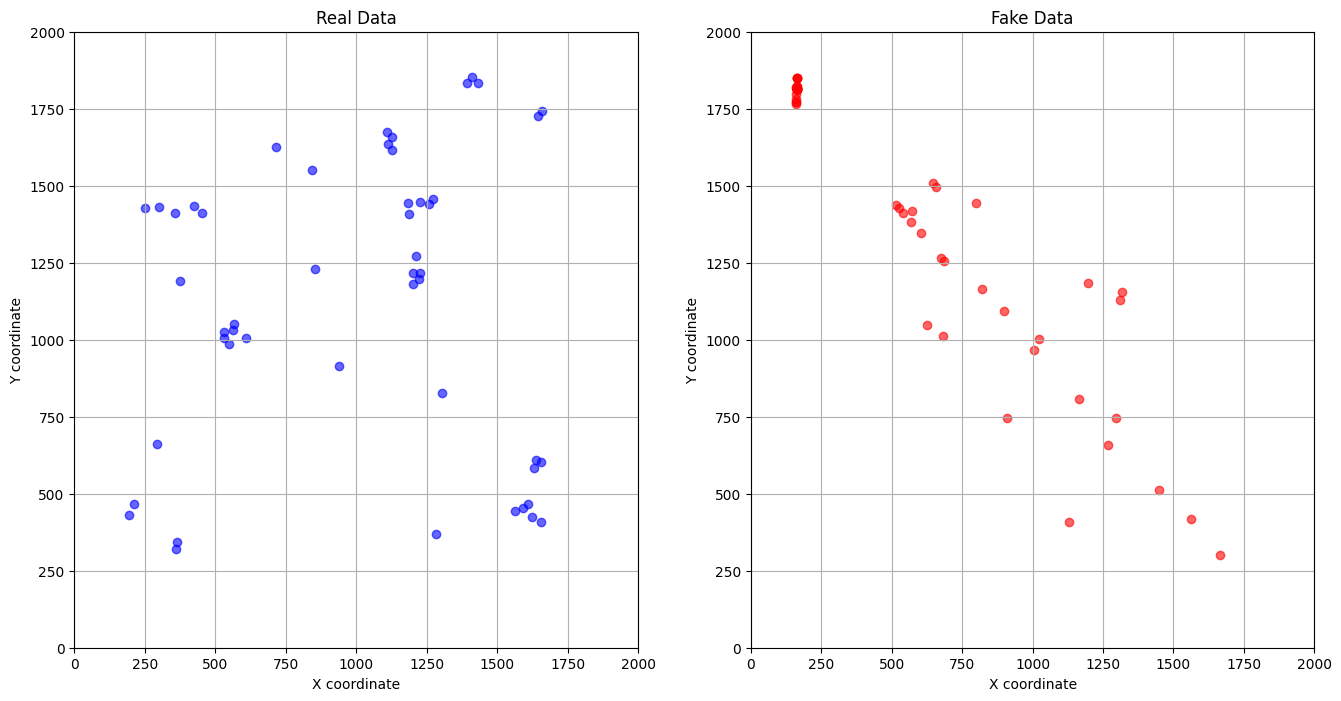

In [149]:
import torch
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from tqdm import tqdm
import matplotlib.animation as animation

def evaluate_and_plot(dataset, generator_model, discriminator_model, device, plot_interval=10):
    """
    Evaluates the generator model on the dataset and plots real vs. fake graph node features.
    Collects all graphs during evaluation and plots them separately.

    Parameters:
    - dataset: The dataset containing graph sequences.
    - generator_model: The trained graph generator model.
    - discriminator_model: The discriminator model (used to get predictions).
    - device: Device (CPU/GPU) to run the models.
    - plot_interval: Interval at which plots are generated.
    """
    generator_model.eval()
    discriminator_model.eval()

    # Collect real and fake graph data
    real_graphs = []
    fake_graphs = []

    with torch.no_grad():
        for idx, (seq, next_graph_of_seq) in tqdm(enumerate(dataset), desc='Evaluating', total=len(dataset)):
            seq = [graph.to(device) for graph in seq]
            real_next_graph_of_seq = next_graph_of_seq.to(device)

            # Generate fake graph data
            fake_graph_node_feats = generator_model(seq)
            edge_index = get_edges_tensor(fake_graph_node_feats, threshold=75)
            fake_next_graph_of_seq = Data(x=fake_graph_node_feats, edge_index=edge_index).to(device)

            # Store graphs
            real_graphs.append(real_next_graph_of_seq)
            fake_graphs.append(fake_next_graph_of_seq)

    # Animate results
    animate_graphs(real_graphs, fake_graphs, plot_interval=plot_interval)

def animate_graphs(real_graphs, fake_graphs, plot_interval=1):
    """
    Animates the nodes of real and fake graphs side by side on separate scatter plots.

    Parameters:
    - real_graphs: List of torch_geometric.data.Data objects containing the real graph data.
    - fake_graphs: List of torch_geometric.data.Data objects containing the generated graph data.
    - plot_interval: Interval at which plots are generated.
    """
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))

    def init():
        for ax in axs:
            ax.clear()
            ax.set_xlim(0, 2000)
            ax.set_ylim(0,2000)
            ax.grid(True)
        axs[0].set_title('Real Data')
        axs[0].set_xlabel('X coordinate')
        axs[0].set_ylabel('Y coordinate')
        axs[1].set_title('Fake Data')
        axs[1].set_xlabel('X coordinate')
        axs[1].set_ylabel('Y coordinate')

    def update(frame):
        real_graph = real_graphs[frame]
        fake_graph = fake_graphs[frame]

        real_node_feats = real_graph.x.cpu().numpy()
        fake_node_feats = fake_graph.x.cpu().numpy()

        real_x = real_node_feats[:, 0]
        real_y = real_node_feats[:, 1]
        fake_x = fake_node_feats[:, 0]
        fake_y = fake_node_feats[:, 1]

        axs[0].clear()
        axs[1].clear()

        axs[0].scatter(real_x, real_y, c='blue', label='Real Data', alpha=0.6)
        axs[1].scatter(fake_x, fake_y, c='red', label='Fake Data', alpha=0.6)

        for ax in axs:
            ax.set_xlim(0, 2000)
            ax.set_ylim(0, 2000)
            ax.grid(True)
        axs[0].set_title('Real Data')
        axs[0].set_xlabel('X coordinate')
        axs[0].set_ylabel('Y coordinate')
        axs[1].set_title('Fake Data')
        axs[1].set_xlabel('X coordinate')
        axs[1].set_ylabel('Y coordinate')

    ani = animation.FuncAnimation(fig, update, frames=range(0, len(real_graphs), plot_interval), init_func=init, interval=10)
    ani.save('boid_animation.gif', writer='pillow')
    plt.show()

# Example usage
device = torch.device('cpu')

# Ensure the following functions and variables are defined:
# dataset, generator_model, discriminator_model, get_edges_tensor

# Evaluate and plot with a plot interval of 10
evaluate_and_plot(dataset_testing, generator_model, discriminator_model, device, plot_interval=1)
